In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import dataset
from torch.optim import Adam
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.transforms as transforms 

import numpy as np


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 


In [0]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])

def get_data_loader(dataset_location, batch_size):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader



In [0]:
train_loader, valid_loader, test_loader = get_data_loader("svhn", 32)


  0%|          | 0/182040794 [00:00<?, ?it/s]

182042624it [00:07, 23721829.89it/s]                               
  0%|          | 0/64275384 [00:00<?, ?it/s]

64282624it [00:04, 13745525.82it/s]                              


In [0]:
print('trainset length : ', len(train_loader.dataset))
print('validset length : ', len(valid_loader.dataset))
print('testset length  : ', len(test_loader.dataset))

trainset length :  65931
validset length :  7326
testset length  :  26032


#VAE

Architecture inspired from https://github.com/eelxpeng/UnsupervisedDeepLearning-Pytorch/blob/master/udlp/autoencoder/convVAE.py

In [0]:
# Using GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class VAE(nn.Module):
    def __init__(self, L=100):
        super(VAE, self).__init__()
        self.L = L
        
        self.encoder = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Conv2d(128, 256, kernel_size=4),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    )
        self.params = nn.Linear(256, self.L*2)
        self.linear = nn.Linear(self.L, 256)
        self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(256, 128, kernel_size=4),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),                    
                    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
                    nn.Tanh()
                    )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 256)
        return self.params(x)

    def reparameterize(self, q_params):
        mu, log_sigma = q_params[:,:self.L], q_params[:,self.L:]
        sigma = 1e-10 + torch.sqrt(torch.exp(log_sigma))

        e = torch.randn(q_params.size(0), self.L, device=device)
        z = mu + sigma * e
        return z, mu, log_sigma, sigma

    def decode(self, z):
        z = self.linear(z)
        z = self.decoder(z.view(z.size(0), 256, 1, 1))
        return z

    def forward(self, x):
        q_params = self.encode(x)
        z, mu, log_sigma, sigma = self.reparameterize(q_params)
        recon_x = self.decode(z)
        return recon_x, mu, log_sigma, sigma


def ELBO(x, recon_x, mu, sigma):
    """
    Function that computes the negative ELBO
    """
    # Compute KL Divergence
    kld = 0.5 * torch.sum(-1 - torch.log(sigma ** 2) + mu ** 2 + sigma ** 2 )
    # Compute reconstruction error
    logpx_z = F.mse_loss(recon_x, x, reduction='sum')
    return logpx_z + kld 



In [0]:
def train(model, train_loader, valid_loader, n_epochs=50):
    dataloader = {"Train": train_loader,
                  "Valid": valid_loader}
    optimizer = Adam(model.parameters(), lr=3*1e-4, eps=1e-4)

    for epoch in range(n_epochs):
        epoch += 1
        # print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss = 0
        valid_loss = 0

        for loader in ["Train", "Valid"]:
            if loader != "Valid":
                model.train()
            else:
                model.eval()

            for idx, (imgs, _) in enumerate(dataloader[loader], 1):
                optimizer.zero_grad()
                imgs = imgs.to(device)
                recon_img, mu, log_sigma, sigma = model(imgs)

                loss = ELBO(img, recon_imgs, mu, sigma)

                if loader != "Valid":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                else:
                    valid_loss += loss.item()
                if idx % 1000 == 0 and loader == "Train":
                    print('\tTrain ELBO: {:.6f}'.format(loss.item()/img.size(0)))

            if loader != "Valid":
                train_epoch_loss =  train_loss /len(dataloader[loader].dataset)
                print("Epoch {} - Train ELBO: {:.6f}".format(epoch, train_epoch_loss))
            else:
                valid_epoch_loss = valid_loss / len(dataloader[loader].dataset)
                print("Epoch {} - Valid ELBO: {:.6f}".format(epoch, valid_epoch_loss))
    return train_epoch_loss, valid_epoch_loss

In [0]:
def view_images(x, recon_x):
  n = min(x.size(0), 8)
  comparison = torch.cat([x.view(-1, 3, 32, 32)[:n], recon_x.view(-1, 3, 32, 32)[:n]])
  save_image(comparison.data.cpu(),
            )

In [0]:
vae = VAE()
vae = vae.to(device)
train(vae, train_loader, valid_loader)

In [0]:
path = F"/content/gdrive/My Drive/vae.pt" 
torch.save(vae.state_dict(), path)

In [0]:
vae = VAE()
model_save_name = 'vae.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
vae.load_state_dict(torch.load(path))

## Qualitative Evaluation

### 1. Provide visual samples.

In [0]:
def generate(model, n_samples=25, nrow=5, eps=0):
    plt.figure(figsize=(8,8))
    x = torch.randn(n_samples, 100).to(device)
    e = torch.Tensor(n_samples, 100)
    e.fill_(eps)
    
    z = x + e
    samples = model.decode(z)
    samples = samples.detach().cpu()
    print(samples.shape)
    grid = torchvision.utils.make_grid(samples, nrow=nrow, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))


torch.Size([25, 3, 32, 32])


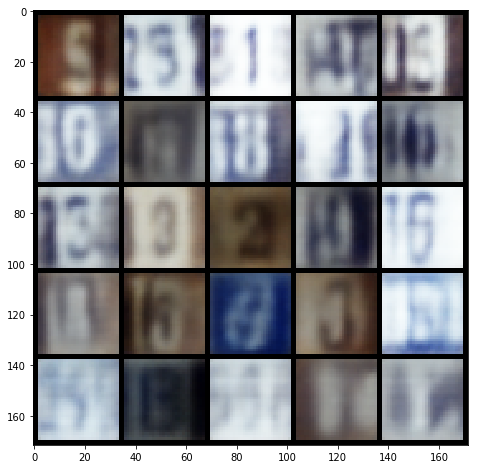

In [0]:
generate(vae)

torch.Size([25, 3, 32, 32])


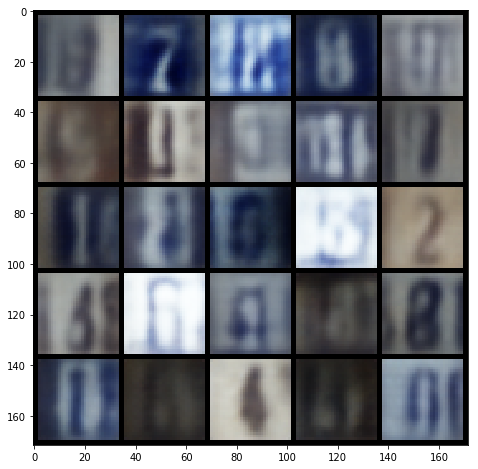

In [0]:
generate(vae)


torch.Size([25, 3, 32, 32])


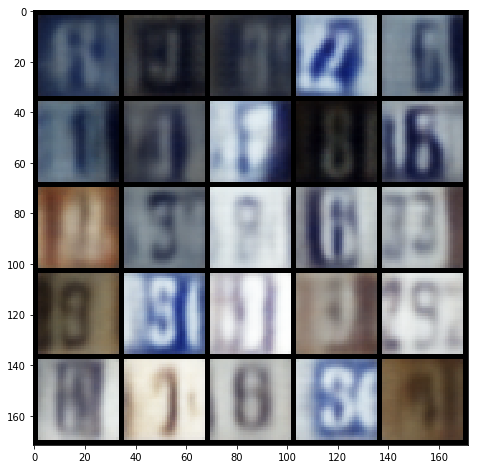

In [0]:
generate(vae)

### 2. Check if the model has learned a disentangled representation in the latent space.

In [0]:
def generate_with_perturbation(model, dim=100, nrow=10, eps=0):
    plt.figure(figsize=(8,8))
    
    # sample from prior and repeat that tensor the number of dimensions
    z = torch.randn(dim)
    z = z.repeat(dim, 1)
    
    # apply perturbation using epsilon 
    for i in range(dim):
      z[i][i] += eps
      
    samples = model.decode(z)
    samples = samples.detach().cpu()
    grid = torchvision.utils.make_grid(samples, nrow=nrow, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))


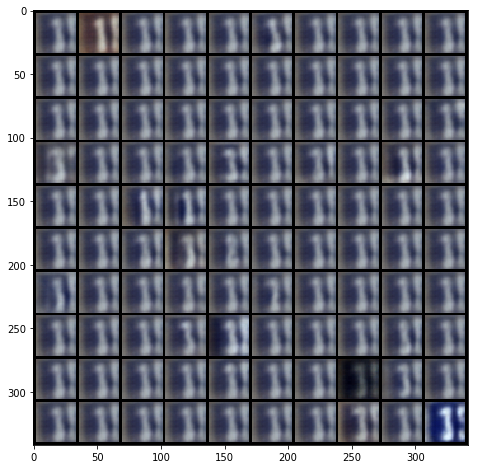

In [0]:
generate_with_perturbation(vae, eps=-1.5)

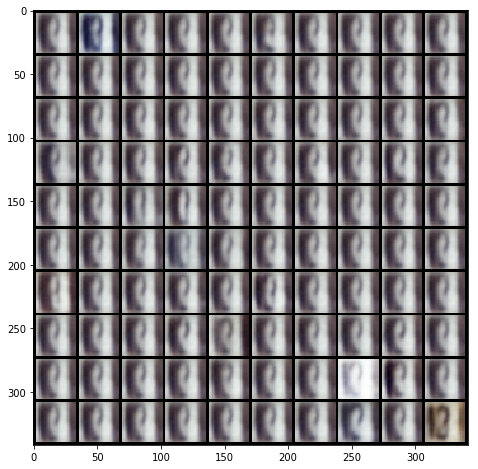

In [0]:
generate_with_perturbation(vae, eps=1.5)

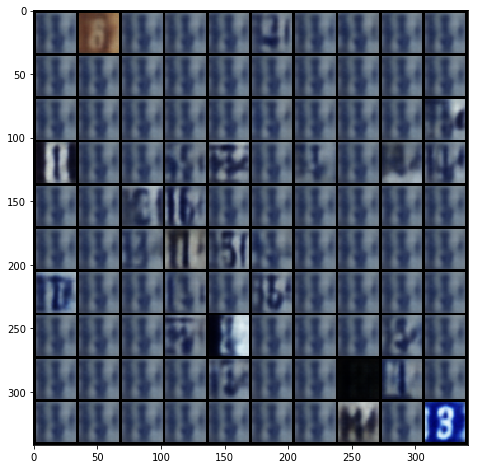

In [0]:
generate_with_perturbation(vae, eps=-5)

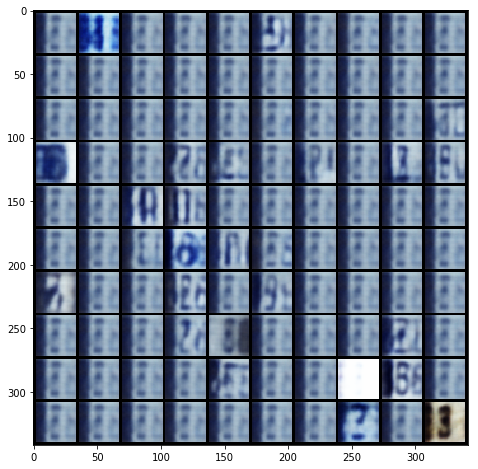

In [0]:
generate_with_perturbation(vae, eps=5)

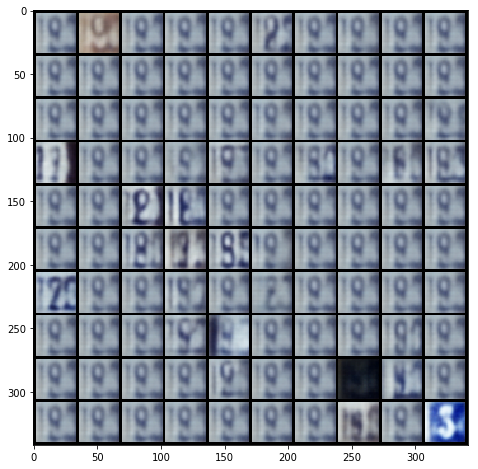

In [0]:
generate_with_perturbation(vae, eps=-3)

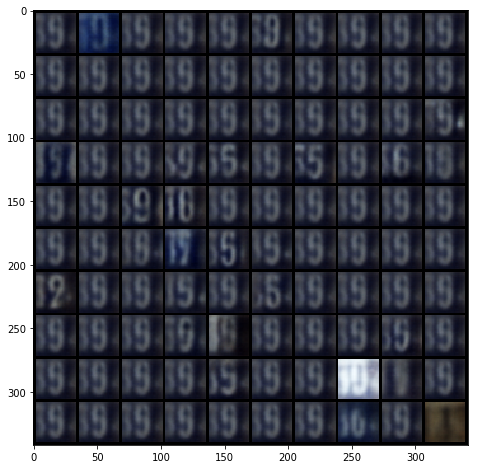

In [0]:
generate_with_perturbation(vae, eps=3)

### 3. Compare between interpolating in the data space and in the latent space.

In [0]:
def interpolation(model):
  model.eval()
  alpha = np.around(np.arange(0.0, 1.0, 0.1), 1)
  
  # Latent space interpolation
  z0 = torch.randn(1, 100).to(device)
  z1 = torch.randn(1, 100).to(device)
  samples = torch.zeros((10,3,32,32))
  for idx, a in enumerate(alpha):
    z = a * z0 + (1 - a) * z1
    samples[idx] = model.decode(z).detach().cpu()
   
  latent_grid = torchvision.utils.make_grid(samples, nrow=10, normalize=True)

  # Data space interpolation
  x0 = model.decode(z0)
  x0 = x0.detach().cpu()
  x1 = model.decode(z1)
  x1 = x1.detach().cpu()
  samples = torch.zeros((10,3,32,32))
  for idx, a in enumerate(alpha):
    samples[idx] = a * x0 + (1 - a) * x1

  data_grid = torchvision.utils.make_grid(samples, nrow=10, normalize=True)

  return latent_grid, data_grid

In [0]:
latent_grid, data_grid = interpolation(vae)
latent_grid1, data_grid1 = interpolation(vae)
latent_grid2, data_grid2 = interpolation(vae)
latent_grid3, data_grid3 = interpolation(vae)

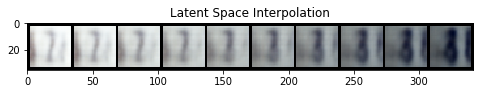

In [0]:
plt.figure(figsize=(8,8))
plt.title('Latent Space Interpolation')
plt.imshow(latent_grid.permute(1, 2, 0))

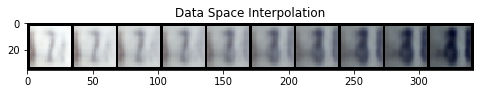

In [0]:
plt.figure(figsize=(8,8))
plt.title('Data Space Interpolation')
plt.imshow(data_grid.permute(1, 2, 0))

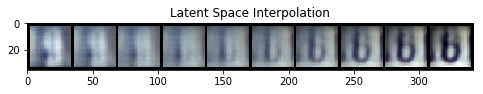

In [0]:
plt.figure(figsize=(8,8))
plt.title('Latent Space Interpolation')
plt.imshow(latent_grid1.permute(1, 2, 0))

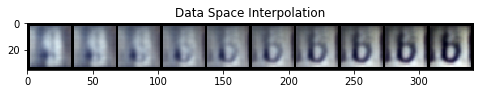

In [0]:
plt.figure(figsize=(8,8))
plt.title('Data Space Interpolation')
plt.imshow(data_grid1.permute(1, 2, 0))

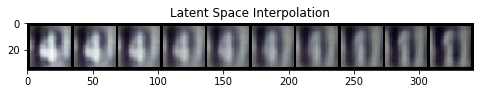

In [0]:
plt.figure(figsize=(8,8))
plt.title('Latent Space Interpolation')
plt.imshow(latent_grid2.permute(1, 2, 0))

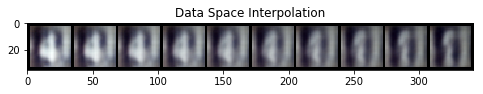

In [0]:
plt.figure(figsize=(8,8))
plt.title('Data Space Interpolation')
plt.imshow(data_grid2.permute(1, 2, 0))

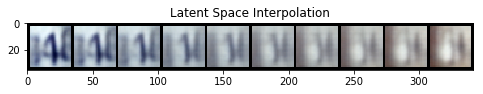

In [0]:
plt.figure(figsize=(8,8))
plt.title('Latent Space Interpolation')
plt.imshow(latent_grid3.permute(1, 2, 0))

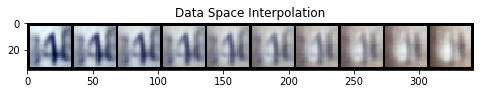

In [0]:
plt.figure(figsize=(8,8))
plt.title('Data Space Interpolation')
plt.imshow(data_grid3.permute(1, 2, 0))

## Quantitative Evaluation

In [0]:
def save_samples(model, path, i):
  z = torch.randn(1, 100).to(device)
  samples = model.decode(z)
  samples = samples.cpu()
  save_image(samples, path + "sample{}.png".format(i), normalize=True)

In [0]:
vae_path = "./gdrive/My Drive/vae/sample_directory/samples/"

In [0]:
# Generate and save 1000 samples
for i in range(1000):
  save_samples(vae, vae_path, i)


In [250]:
! python ./IFT6135H19_A3/assignment3/Q3/score_fid.py ./gdrive/My\ Drive/vae/ --model=./svhn_classifier.pt

Using downloaded and verified file: svhn/test_32x32.mat
FID score: 15273.357722675399
